In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [94]:
!pip install WordCloud

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import RegexpTokenizer  
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer  
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

In [3]:
df= pd.read_csv("phishing_site_urls.csv")

In [4]:
df.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [5]:
df.isnull().sum()

URL      0
Label    0
dtype: int64

#### Removind Duplicates in Dataset Data.

The data set contains some duplicate data. You should probably remove them. Duplicates are an extreme case of nonrandom sampling, and they bias your fitted model. Including them will essentially lead to the model overfitting this subset of points.

In [6]:
df.describe()

,URL,Label
count,549346,549346
unique,507195,2
top,jhomitevd2abj3fk.tor2web.org/,good
freq,52,392924


In [7]:
df = df.drop_duplicates()

#### Let study the data!

The dataset contains a total of 507,196 unique rows and 2 columns. The data consists of URLs and each URL has a lable which denotes if it is a phishy URL with the label 'bad' and for a non phishy URL it has the lable 'good'.

<AxesSubplot:xlabel='Label', ylabel='count'>

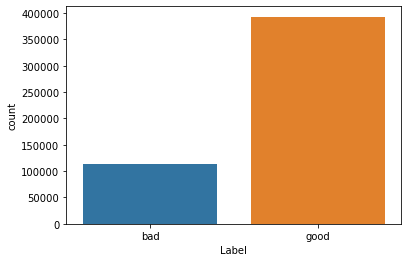

In [8]:
sns.countplot(x="Label",data=df)

### Preprocession

Now we have to gather all the proper words (tokens) from the URLs using RegexpTokenizer() method from the nltk method.

We pass "r'[A-Za-z]+'" to consider only alphabets for forming tokens.

In [9]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')

In [10]:
df['text_tokenized'] = df.URL.map(lambda t: tokenizer.tokenize(t))

In [ ]:
df.head()

,URL,Label,text_tokenized
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe..."
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin..."
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"[serviciosbys, com, paypal, cgi, bin, get, int..."
3,mail.printakid.com/www.online.americanexpress....,bad,"[mail, printakid, com, www, online, americanex..."
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"[thewhiskeydregs, com, wp, content, themes, wi..."


### SnowballStemmer

Snowball is a small string processing language, gives root words

Difference Between Porter Stemmer and Snowball Stemmer:
* Snowball Stemmer is more aggressive than Porter Stemmer.
* Some issues in Porter Stemmer were fixed in Snowball Stemmer.
* There is only a little difference in the working of these two.

In [11]:
root_words = SnowballStemmer("english")
df['root_words'] = df['text_tokenized'].map(lambda l: [root_words.stem(word) for word in l])

In [16]:
df.head()

,URL,Label,text_tokenized,root_words
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe...","[nobel, it, ffb, d, dca, cce, f, login, skype,..."
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin...","[www, dghjdgf, com, paypal, co, uk, cycgi, bin..."
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"[serviciosbys, com, paypal, cgi, bin, get, int...","[serviciosbi, com, paypal, cgi, bin, get, into..."
3,mail.printakid.com/www.online.americanexpress....,bad,"[mail, printakid, com, www, online, americanex...","[mail, printakid, com, www, onlin, americanexp..."
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"[thewhiskeydregs, com, wp, content, themes, wi...","[thewhiskeydreg, com, wp, content, theme, wide..."


### Taking all the root words into a sentence. 
This is done to pass into CountVectorizer function later on.

In [17]:
df['text_sent'] = df['root_words'].map(lambda l: ' '.join(l))
df.head()

,URL,Label,text_tokenized,root_words,text_sent
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe...","[nobel, it, ffb, d, dca, cce, f, login, skype,...",nobel it ffb d dca cce f login skype com en cg...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin...","[www, dghjdgf, com, paypal, co, uk, cycgi, bin...",www dghjdgf com paypal co uk cycgi bin webscrc...
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"[serviciosbys, com, paypal, cgi, bin, get, int...","[serviciosbi, com, paypal, cgi, bin, get, into...",serviciosbi com paypal cgi bin get into herf s...
3,mail.printakid.com/www.online.americanexpress....,bad,"[mail, printakid, com, www, online, americanex...","[mail, printakid, com, www, onlin, americanexp...",mail printakid com www onlin americanexpress c...
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"[thewhiskeydregs, com, wp, content, themes, wi...","[thewhiskeydreg, com, wp, content, theme, wide...",thewhiskeydreg com wp content theme widescreen...


### Visualizing Data
Spliting Data into data with bad lables and good lables

In [18]:
bad_sites = df[df.Label == 'bad']
good_sites = df[df.Label == 'good']
bad_sites.head()


,URL,Label,text_tokenized,root_words,text_sent
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe...","[nobel, it, ffb, d, dca, cce, f, login, skype,...",nobel it ffb d dca cce f login skype com en cg...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin...","[www, dghjdgf, com, paypal, co, uk, cycgi, bin...",www dghjdgf com paypal co uk cycgi bin webscrc...
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"[serviciosbys, com, paypal, cgi, bin, get, int...","[serviciosbi, com, paypal, cgi, bin, get, into...",serviciosbi com paypal cgi bin get into herf s...
3,mail.printakid.com/www.online.americanexpress....,bad,"[mail, printakid, com, www, online, americanex...","[mail, printakid, com, www, onlin, americanexp...",mail printakid com www onlin americanexpress c...
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"[thewhiskeydregs, com, wp, content, themes, wi...","[thewhiskeydreg, com, wp, content, theme, wide...",thewhiskeydreg com wp content theme widescreen...


In [19]:
good_sites.head()

,URL,Label,text_tokenized,root_words,text_sent
18231,esxcc.com/js/index.htm?us.battle.net/noghn/en/...,good,"[esxcc, com, js, index, htm, us, battle, net, ...","[esxcc, com, js, index, htm, us, battl, net, n...",esxcc com js index htm us battl net noghn en r...
18232,wwweira¯&nvinip¿ncH¯wVö%ÆåyDaHðû/ÏyEùuË\nÓ6...,good,"[www, eira, nvinip, ncH, wV, yDaH, yE, u, rT, ...","[www, eira, nvinip, nch, wv, ydah, ye, u, rt, ...",www eira nvinip nch wv ydah ye u rt u g m i xz...
18233,'www.institutocgr.coo/web/media/syqvem/dk-óij...,good,"[www, institutocgr, coo, web, media, syqvem, d...","[www, institutocgr, coo, web, media, syqvem, d...",www institutocgr coo web media syqvem dk ij r ...
18234,Yìê koãÕ»Î§DéÎl½ñ¡ââqtò¸/à; Í,good,"[Y, ko, D, l, qt]","[y, ko, d, l, qt]",y ko d l qt
18236,ruta89fm.com/images/AS@Vies/1i75cf7b16vc<Fd16...,good,"[ruta, fm, com, images, AS, Vies, i, cf, b, vc...","[ruta, fm, com, imag, as, vie, i, cf, b, vc, f...",ruta fm com imag as vie i cf b vc f d b g sd v...


In [20]:
print(list(STOPWORDS)[:10])

["there's", 'both', "let's", 'why', 'before', "he's", 'i', 'there', 'after', "you're"]


Wordcloud for the good urls.

### Model Creation
#### CountVectorizer

CountVectorizer tokenizes(tokenization means breaking down a sentence or paragraph or any text into words) the text along with performing very basic preprocessing like removing the punctuation marks, converting all the words to lowercase, etc.


In [21]:
c = CountVectorizer()
cv = c.fit_transform(df.text_sent)

The text has been preprocessed, tokenized(word-level tokenization: means each word is a separate token), and represented as a sparse matrix. The best part is it ignores single character during tokenization like I and a.

In [22]:
print(list(c.vocabulary_)[:10])

['nobel', 'it', 'ffb', 'dca', 'cce', 'login', 'skype', 'com', 'en', 'cgi']


In [23]:
print('The length of vocabulary', len(c.get_feature_names()))
print('The shape is', cv.shape)

#This means 507196 unique urls are there in the dataset and 350837 unique words in the dataset

The length of vocabulary 350836
The shape is (507196, 350836)


#### Splitting the dataset

In [24]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(cv, df.Label,test_size=0.3, random_state=42)

__Decision Tree Classification__

In [25]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth = 5)
tree.fit(Xtrain, Ytrain)

DecisionTreeClassifier(max_depth=5)

In [26]:
from sklearn.metrics import accuracy_score
y_test_tree = tree.predict(Xtest)
y_train_tree = tree.predict(Xtrain)

In [27]:
acc_train_tree = accuracy_score(Ytrain,y_train_tree)
acc_test_tree = accuracy_score(Ytest,y_test_tree)
print("Decision Tree: Accuracy on training Data: {:.3f}".format(acc_train_tree))
print("Decision Tree: Accuracy on test Data: {:.3f}".format(acc_test_tree))

Decision Tree: Accuracy on training Data: 0.848
Decision Tree: Accuracy on test Data: 0.849


__Random Forest__

In [34]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(max_depth=10)
forest.fit(Xtrain, Ytrain)

RandomForestClassifier(max_depth=10)

In [35]:
from sklearn.metrics import accuracy_score
y_test_forest = forest.predict(Xtest)
y_train_forest = forest.predict(Xtrain)

In [36]:
acc_train_forest = accuracy_score(Ytrain,y_train_forest)
acc_test_forest = accuracy_score(Ytest,y_test_forest)

print("Random forest: Accuracy on training Data: {:.3f}".format(acc_train_forest))
print("Random forest: Accuracy on test Data: {:.3f}".format(acc_test_forest))

Random forest: Accuracy on training Data: 0.774
Random forest: Accuracy on test Data: 0.776


#### Logistic Regression
Logistic Regression is a classification algorithm. It's a technique for predicting a binary outcome from a series of independent variables.

A binary outcome is one in which there are only two options: the occurrence occurs (1) or it does not occur (0). Independent variables are variables or factors that have the ability to affect the result (or dependent variable).

When dealing with binary data, the best method of analysis to use is logistic regression. When the performance or dependent variable is dichotomous or categorical in nature (e.g., "yes" or "no," "pass" or "fail," and so on), you're dealing with binary results.


In [ ]:
lr = LogisticRegression(max_iter=507197)
lr.fit(Xtrain,Ytrain)

LogisticRegression(max_iter=507197)

lr.score(Xtrain,Ytrain)

In [ ]:
lr.score(Xtest,Ytest)

0.9619542715186088

In [ ]:
ypred = lr.predict(Xtest)

<AxesSubplot:>

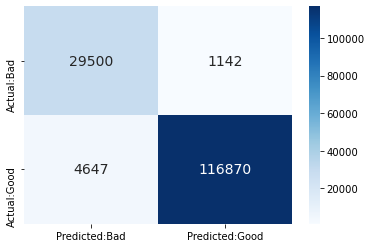

In [ ]:
con_mat = pd.DataFrame(confusion_matrix(ypred, Ytest),columns = ['Predicted:Bad', 'Predicted:Good'],index = ['Actual:Bad', 'Actual:Good'])
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='g', cmap="Blues", annot_kws = {'size': 14})

In [ ]:
print('\nCLASSIFICATION REPORT\n')
print(classification_report(ypred, Ytest, target_names =['Bad','Good']))


CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.86      0.96      0.91     30642
        Good       0.99      0.96      0.98    121517

    accuracy                           0.96    152159
   macro avg       0.93      0.96      0.94    152159
weighted avg       0.96      0.96      0.96    152159



#### Conclusion
From this we can see that Logistic Regression gives a better accuracy when comaperd to the Decision Tree Algorithm and Random Forest ALgorithm. Hence Logistic Regression is the appropriate algorithm to use for classification of the URLs.

In [108]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(df.URL, df.Label,test_size=0.3, random_state=42)

In [109]:
pipeline_ls = make_pipeline(CountVectorizer(tokenizer = RegexpTokenizer(r'[A-Za-z]+').tokenize,stop_words='english'), LogisticRegression(max_iter=507197))

In [ ]:
pipeline_ls.fit(Xtrain,Ytrain)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(stop_words='english',
                                 tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[A-Za-z]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>)),
                ('logisticregression', LogisticRegression(max_iter=507197))])

In [107]:
phish = [ ]
n = int(input("Enter number of elements : "))
 
for i in range(0, n):
    ele = [input()]
    phish.append(ele)
    result1 = pipeline_ls.predict(ele)
    print(result1)

['bad']
['good']
['bad']
